## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
nc_fn = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/bore_ex.nc"
ds = xr.open_dataset(nc_fn)

In [3]:
times = ds.time

In [4]:
img_array = ds.sel(time=times[0]).rad255.values

In [5]:
img_array_thresh = np.where(img_array == 255, 0., img_array)

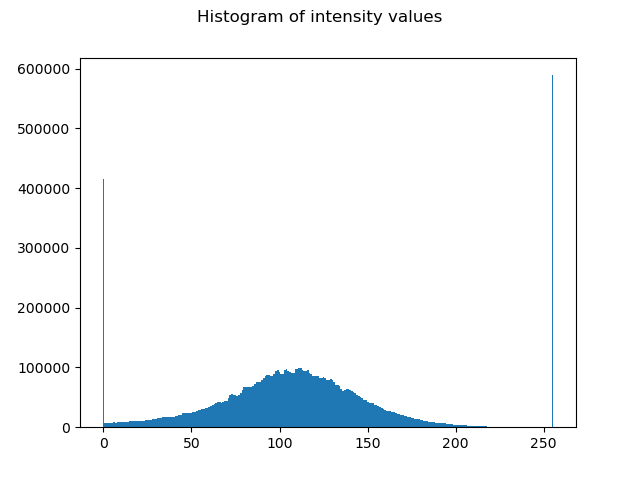

In [6]:
F, ax = plt.subplots()
F.suptitle("Histogram of intensity values")
ax.hist(img_array.ravel(), bins=256, range=(-0.5, 255.5));

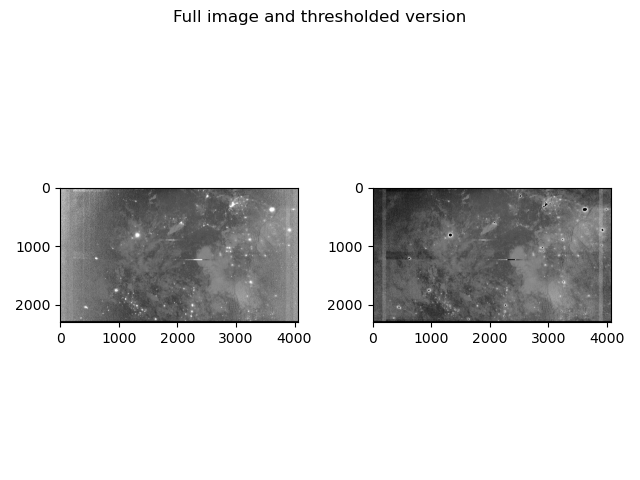

In [9]:
F, ax = plt.subplots(1, 2)
F.suptitle("Full image and thresholded version")
ax[0].imshow(img_array, cmap='gray', clim=(0, 255))
ax[1].imshow(img_array_thresh, cmap='gray', clim=(0, 255))
F.tight_layout()

In [28]:
xystart = (3276, 711)
xyend = (3395, 975)
img_crop = img_array[slice(xystart[1], xyend[1]), xystart[0]:xyend[0]]
img_crop_thresh = img_array_thresh[xystart[1]:xyend[1], xystart[0]:xyend[0]]

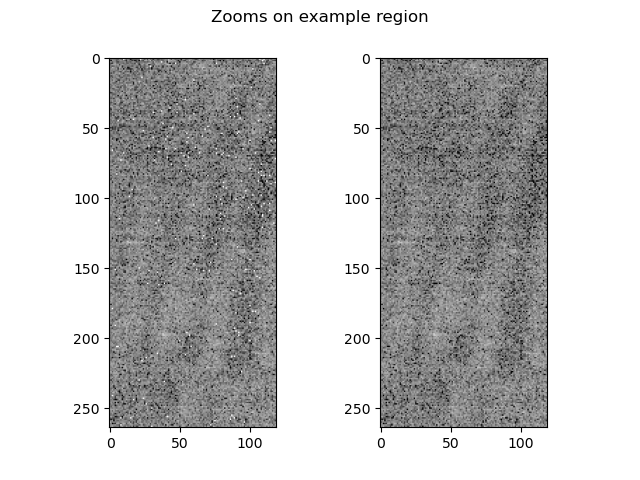

In [29]:
F, ax = plt.subplots(1, 2)
F.suptitle("Zooms on example region")
ax[0].imshow(img_crop, cmap='gray', clim=(0, 255))
ax[1].imshow(img_crop_thresh, cmap='gray', clim=(0, 255))

## Set up autocorrelation functions

In [30]:
def auto_correlate(img, x, y, width, height, xrange=None, yrange=None):
    if xrange==None:
        xrange = width//2
    if yrange==None:
        yrange = height//2
        
    img_crop = img[y:y+height, x:x+width]
    img_crop = (img_crop - img_crop.mean()) / img_crop.std()
    
    normalizer = np.sum(img_crop * img_crop)
    
    full_xrange = range(0, 2*xrange)
    full_yrange = range(0, 2*yrange)
    
    corr_img = np.zeros((len(full_yrange), len(full_xrange)))
    
    for xt in full_xrange:
        for yt in full_yrange:
            x_ref = x + (xt - xrange)
            y_ref = y + (yt - yrange)
            img_comp = img[y_ref:y_ref+height, x_ref:x_ref+width]
            img_comp = (img_comp - img_comp.mean()) / img_comp.std()
            corr_img[yt, xt] = np.sum(img_comp * img_crop) / normalizer
    
    corr_img[yrange, xrange] = np.NaN
            
    return corr_img

In [31]:
def local_auto_corr(img, width, height):
    xnum = (img.shape[1] // width) - 1
    ynum = (img.shape[0] // height) - 1
    
    x_vals = [width // 2 + i * width for i in range(xnum)]
    y_vals = [height // 2 + i * height for i in range(ynum)]
    
    corr_im = np.full(img.shape, np.NaN)
    
    for x in x_vals:
        for y in y_vals:
            corr_im_temp = auto_correlate(img, x, y, width, height)
            corr_im[y:y+corr_im_temp.shape[0], x:x+corr_im_temp.shape[1]] = corr_im_temp
            
    return corr_im

## Run autocorrelation on test region

In [33]:
corr_img = auto_correlate(img_array, xystart[0], xystart[1], xyend[0] - xystart[0], xyend[1] - xystart[1])
corr_img_thresh = auto_correlate(img_array_thresh, xystart[0], xystart[1], xyend[0] - xystart[0], xyend[1] - xystart[1])

In [34]:
vmin = min([np.nanmin(corr_img), np.nanmin(corr_img_thresh)])
vmax = max([np.nanmax(corr_img), np.nanmax(corr_img_thresh)])

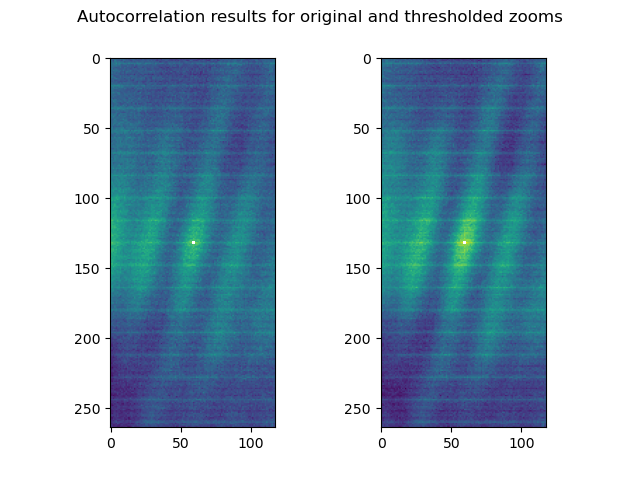

In [35]:
F, ax = plt.subplots(1, 2)
F.suptitle("Autocorrelation results for original and thresholded zooms")
ax[0].imshow(corr_img, cmap='viridis', clim=(vmin, vmax))
ax[1].imshow(corr_img_thresh, cmap='viridis', clim=(vmin, vmax))

## Autocorrelate entire image

In [13]:
square_size = 50

In [14]:
start = timer()
corr_im = local_auto_corr(img_array, square_size, square_size)
print(f'First autocorrelation took {timer() - start} seconds for a {img_array.shape} image')
corr_im_filled = np.where(np.isnan(corr_im), 0.0, corr_im)
start = timer()
corr_im_2 = local_auto_corr(corr_im_filled, square_size, square_size)
print(f'Second autocorrelation took {timer() - start} seconds for a {corr_im.shape} image')

First autocorrelation took 23.32903219999571 seconds for a (924, 510) image
Second autocorrelation took 27.346181699991575 seconds for a (924, 510) image


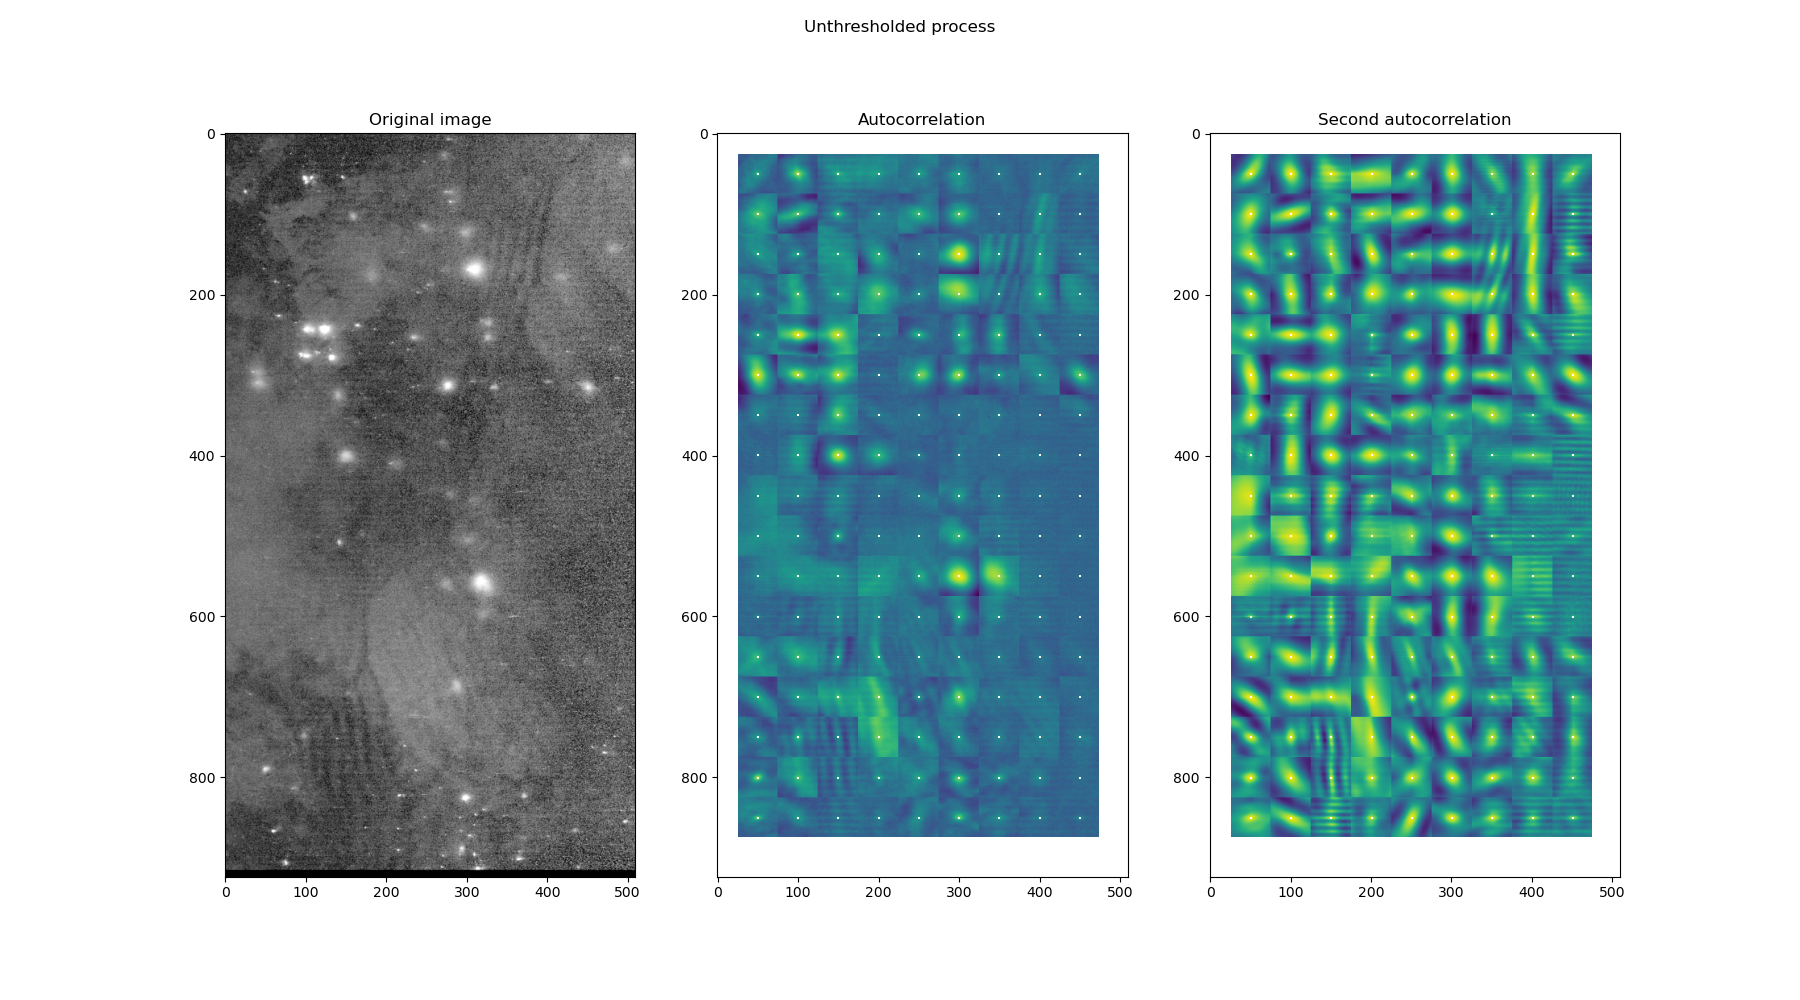

In [15]:
F, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(img_array, cmap='gray', clim=(0, 255))
ax[0].set_title('Original image')
ax[1].imshow(corr_im)
ax[1].set_title('Autocorrelation')
ax[2].imshow(corr_im_2)
ax[2].set_title('Second autocorrelation')
F.suptitle('Unthresholded process');

In [16]:
start = timer()
corr_im_thresh = local_auto_corr(img_array_thresh, square_size, square_size)
print(f'First autocorrelation took {timer() - start} seconds for a {img_array_thresh.shape} image')
corr_im_thresh_filled = np.where(np.isnan(corr_im_thresh), 0.0, corr_im_thresh)
start = timer()
corr_im_thresh_2 = local_auto_corr(corr_im_thresh_filled, square_size, square_size)
print(f'Second autocorrelation took {timer() - start} seconds for a {corr_im_thresh.shape} image')

First autocorrelation took 27.625462099997094 seconds for a (924, 510) image
Second autocorrelation took 29.191949100000784 seconds for a (924, 510) image


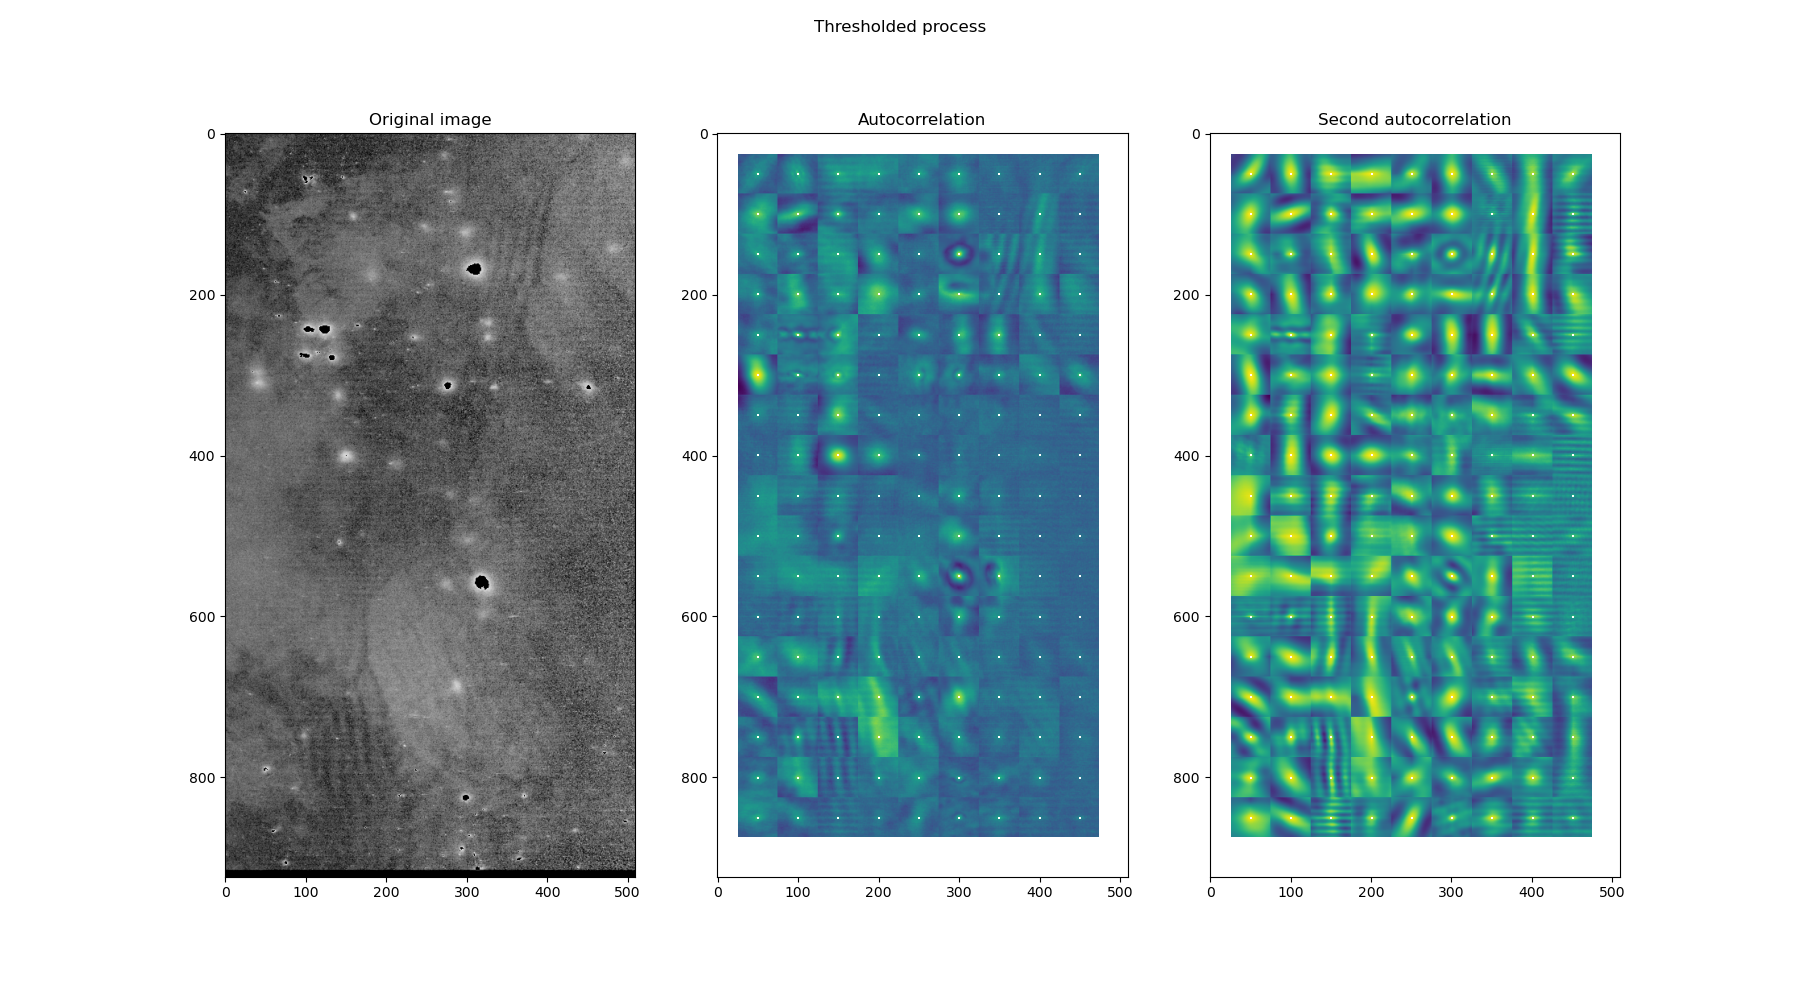

In [17]:
F, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(img_array_thresh, cmap='gray', clim=(0, 255))
ax[0].set_title('Original image')
ax[1].imshow(corr_im_thresh)
ax[1].set_title('Autocorrelation')
ax[2].imshow(corr_im_thresh_2)
ax[2].set_title('Second autocorrelation')
F.suptitle('Thresholded process');

## Synthetic image to test autocorrelation

In [18]:
x = np.linspace(0, 60, 1000)
xdat = np.sin(x)
temp_im = np.stack([xdat]*1000)

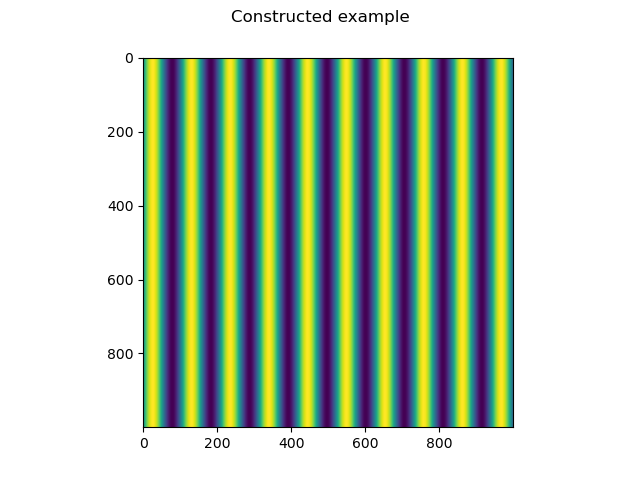

In [19]:
F, ax = plt.subplots()
F.suptitle("Constructed example")
ax.imshow(temp_im)

In [20]:
corr_im = auto_correlate(temp_im, 400, 400, 200, 200)

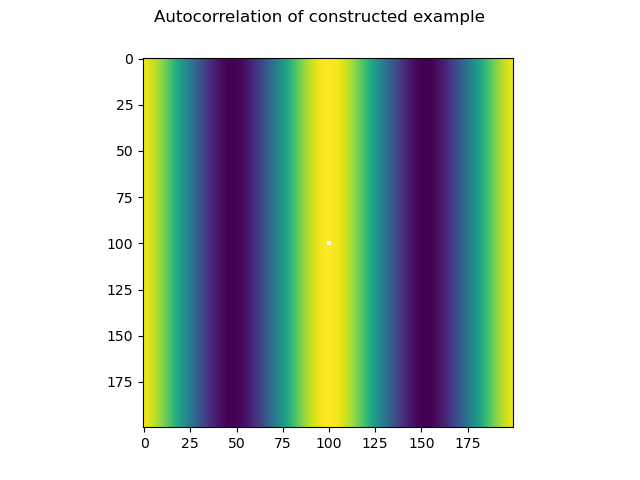

In [21]:
F, ax = plt.subplots()
F.suptitle("Autocorrelation of constructed example")
ax.imshow(corr_im)

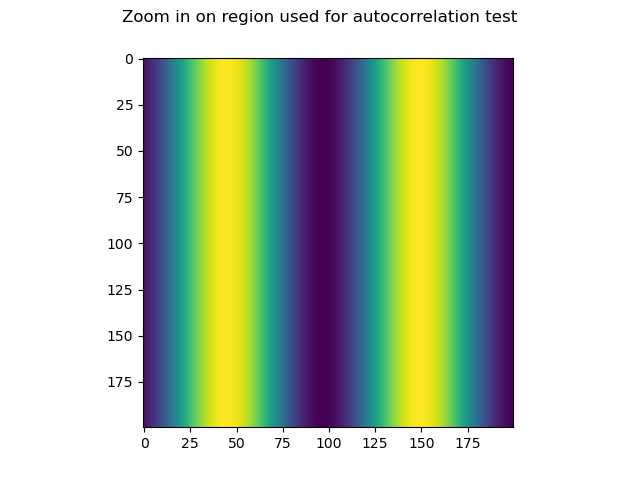

In [22]:
F, ax = plt.subplots()
F.suptitle("Zoom in on region used for autocorrelation test")
ax.imshow(temp_im[400:600, 400:600])

## Try Fourier-based autocorrelation

In [23]:
f_img_crop = scipy.fft.fft(img_crop)

In [24]:
power_spec = (np.abs(f_img_crop))**2

In [25]:
img_crop_corr = np.abs(scipy.fft.fft(power_spec))

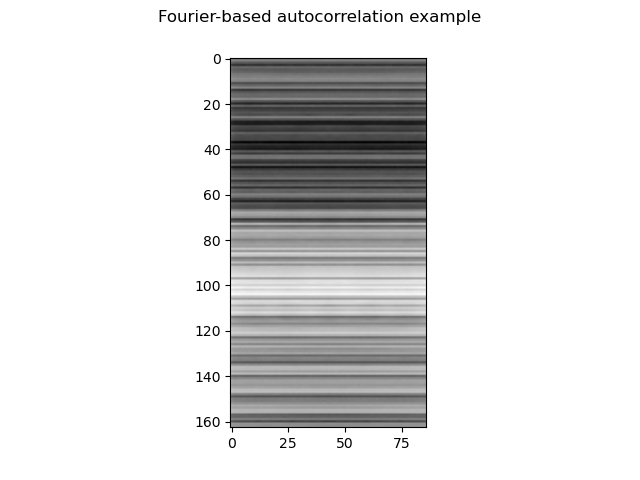

In [26]:
F, ax = plt.subplots()
F.suptitle("Fourier-based autocorrelation example")
ax.imshow(img_crop_corr, cmap='gray')